In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# TensorFlow and tf.keras
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

In [2]:
def load_data_with_augmentation(data_dir, augment=False):
    images = []
    labels = []
    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    for class_id, class_name in enumerate(classes):
        img_dir = os.path.join(data_dir, class_name, 'images').replace("\\","/")
        label_dir = os.path.join(data_dir, class_name, 'labels').replace("\\","/")

        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name).replace("\\","/")
            label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt')).replace("\\","/")

            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = f.readline().strip().split()
                    if len(label) > 0:
                        class_id = int(label[0])
                    else:
                        continue
            else:
                continue

            images.append(img)
            labels.append(class_id)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
    labels = np.array(labels)
    return images, labels

base_dir = 'archive'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')

train_images, train_labels = load_data_with_augmentation(train_dir, augment=False)
val_images, val_labels = load_data_with_augmentation(val_dir, augment=False)

In [3]:
train_images.shape, val_images.shape

((4737, 224, 224, 3), (509, 224, 224, 3))

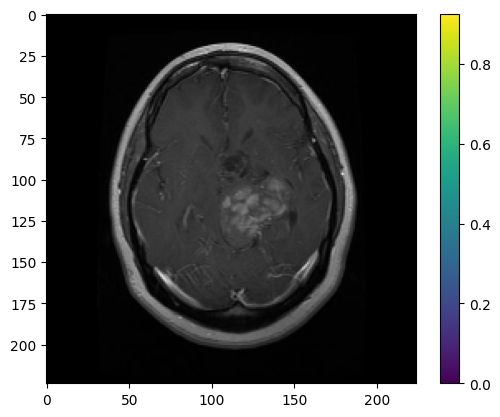

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
def create_tf_dataset(images, labels, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)) if is_training else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 32
train_dataset = create_tf_dataset(train_images, train_labels, batch_size=batch_size, is_training=True)
val_dataset = create_tf_dataset(val_images, val_labels, batch_size=batch_size, is_training=False)

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Adjust number of classes

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# freeze layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [11]:
# Extract features using the base model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
train_features = feature_extractor.predict(train_images)
val_features = feature_extractor.predict(val_images)

# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train a RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_flat, train_labels)
rf_predictions = rf_classifier.predict(val_features_flat)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

149/149 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Random Forest Accuracy: 0.9136


In [12]:
# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(train_features_flat, train_labels)
lr_predictions = lr_classifier.predict(val_features_flat)
lr_accuracy = accuracy_score(val_labels, lr_predictions)
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

Logistic Regression Accuracy: 0.9725


In [16]:
# Compile 
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
# add tensorboard
tensorboard = tf.keras.callbacks.TensorBoard('logs')

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, tensorboard])


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6727 - loss: 0.8006 - val_accuracy: 0.8330 - val_loss: 0.4275
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8188 - loss: 0.4690 - val_accuracy: 0.8566 - val_loss: 0.3655
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8544 - loss: 0.3941 - val_accuracy: 0.7014 - val_loss: 0.7317
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8428 - loss: 0.3930 - val_accuracy: 0.8291 - val_loss: 0.4138
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8805 - loss: 0.3186 - val_accuracy: 0.8409 - val_loss: 0.4187


In [17]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Fully Connected Layer Accuracy: {val_accuracy:.4f}')
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Logistic Regression Accuracy: {lr_accuracy:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8134 - loss: 0.4729
Fully Connected Layer Accuracy: 0.8409
Random Forest Accuracy: 0.9136
Logistic Regression Accuracy: 0.9725
